[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/combine-org/combine-notebooks/binder_colab_testing?labpath=%2Fnotebooks%2Fsedml.ipynb)
<a href="https://colab.research.google.com/github/combine-org/combine-notebooks/blob/main/notebooks/sedml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

# Simple SBOL example

This notebook creates a simple model in [Synthetic Biology Open Language (SBOL) Version 3.0.1](https://sbolstandard.org/docs/SBOL3.0.1.pdf).

## 1) Including libraries and setup

Note: Please change the `colab` flag to `True` if you are using Google Colab.

In [ ]:
colab = False
if colab:
  %pip install git+https://github.com/combine-org/combine-notebooks
  %pip install pyflapjack --quiet
  %pip install loica --quiet
  %pip install sbol3 --quiet
  %pip install sbol_utilities --quiet

In [2]:
from pathlib import Path

import sbol3
from sbol_utilities import component
from flapjack import Flapjack
import loica as lc
import getpass

from combine_notebooks import RESULTS_DIR

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
user = input()
passwd = getpass.getpass()
fj = Flapjack('flapjack.rudge-lab.org:8000') #Web Instance
#fj = Flapjack(url_base='localhost:8000') #Local Instance
fj.log_in(username=user, password=passwd)

## 2) Declaring the SBOL model

These are all the necessary Flapjack objects and ids that we will need for two-way communication.

In [4]:
dna = fj.get('dna', name='J23101_GFP')
if len(dna)==0:
    dna = fj.create('dna', name='J23101_GFP')
vector = fj.get('vector', name='J23101_GFP')
if len(vector)==0:
    vector = fj.create('vector', name='J23101_GFP', dnas=dna.id)
study = fj.get('study', name='Loica testing')
if len(study)==0:
    study = fj.create('study', name='Loica testing', description='Test')
media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

gfp = fj.get('signal', name='GFP')
if len(gfp)==0:
    gfp = fj.create('signal', name='GFP', color='green', description='Simulated green fluorescent protein')

biomass_signal = fj.get('signal', name='OD')


A valid SBOL Document with the sequences and parts that we will use in the design. Here we create the J23101 Operator as an Engineered Region composed by the promoter J23101 and the BASIC RBS1 (derived from BBa_B0033). We create the GFP GeneProduct also as an Engineering Region now composed by GFP CDS, M0050 degradation tag and rrnbT1 terminator. First, we will decalre the SBOL document and set the namespace.

In [5]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

Next, we will create a promoter.  A synthetic promoter is a sequence of DNA that does not exist in nature and which has been designed to control gene expression of a target gene.

In [6]:
j23101, j23101_seq = component.promoter('J23101','tttacagctagctcagtcctaggtattatgctagc ', description='https://synbiohub.org/public/igem/BBa_J23101/1')

Now, we will create a ribosome binding site (RBS), which is a sequence of nucleotides upstream of the start codon of an mRNA transcript that is responsible for the recruitment of a ribosome during the initiation of translation.

In [7]:
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')

Define the promoter and RBS as our first engineered region.

In [8]:
op_j23101 = component.engineered_region('operator_ptet', [j23101,rbs1], description= 'LOICA Operator J23101')

The next step is to create a CoDing Sequence (CDS).  This is a region of DNA or RNA whose sequence determines the sequence of amino acids in a protein.

In [9]:
gfpm3, gfpm3_seq = component.cds('GFP_mut3', 'atgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagcgcgaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaa', description='GFP mut3 Coding Sequence, no BsaI site, no stop codon')

Next, we add a sequence that will ensure the resultant protein susceptible to very fast degradation.

In [10]:
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')

Finally, we will create a terminator sequence. Terminators are genetic parts that usually occur at the end of a gene or operon and cause transcription to stop.

In [11]:
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

Define the CDS, stability element, and terminator as our second engineered region.

In [12]:
gp_gfp = component.engineered_region(f'geneproduct_{gfpm3.display_id}_{m0050.display_id}_{ter1.display_id}', [gfpm3, m0050, ter1], description='LOICA GeneProduct GFP')

Add everything we have just created to the SBOL document.

In [13]:
doc.add([j23101, j23101_seq, rbs1, rbs1_seq, op_j23101, gfpm3, gfpm3_seq, m0050, m0050_seq, ter1, ter1_seq, gp_gfp])

## 3) Validate, save and display SBOL document

Print out all object identities in the SBOL document.  Then validate the document.

In [14]:
for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/J23101
https://github.com/Gonza10V/J23101_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
0


We can save this SBOL as an XML file which is in RDF format. An RDF file is a document written in the Resource Description Framework (RDF) language, which is used to represent information about resources on the web. As you can see in the text, most tags are pointing to a specific URI on the internet.

In [16]:
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
sbol_file = RESULTS_DIR / 'hello_world_sbol.xml'
doc.write(sbol_file)
with open(sbol_file) as f:
   print(f.read())

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:sbol="http://sbols.org/v3#"
>
  <rdf:Description rdf:about="https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1">
    <sbol:displayId>geneproduct_GFP_mut3_M0050_TER1</sbol:displayId>
    <sbol:description>LOICA GeneProduct GFP</sbol:description>
    <rdf:type rdf:resource="http://sbols.org/v3#Component"/>
    <sbol:hasNamespace rdf:resource="https://github.com/Gonza10V"/>
    <sbol:type rdf:resource="https://identifiers.org/SBO:0000251"/>
    <sbol:role rdf:resource="https://identifiers.org/SO:0000804"/>
    <sbol:hasFeature rdf:resource="https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1/SubComponent1"/>
    <sbol:hasFeature rdf:resource="https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1/SubComponent2"/>
    <sbol:hasFeature rdf:resource="https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1/SubComponent3"/>
    <sbol:hasConstraint rdf:re

Instantiated objects are connected with Flapjack through ids and with SBOL through Components.  An inspection of the design can be made by drawing its network representation.

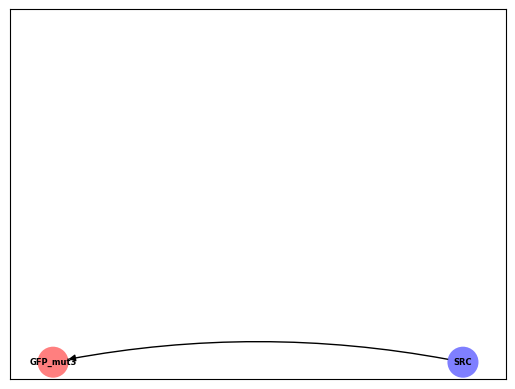

In [17]:
src = lc.GeneticNetwork(vector=vector.id[0])

gfp_rep = lc.Reporter(name='GFP_mut3', degradation_rate=0, signal_id=gfp.id[0], sbol_comp=gp_gfp, color='red')
src.add_reporter(gfp_rep)

j23101_source_gfp = lc.Source(output=gfp_rep, rate=10, sbol_comp=op_j23101)
src.add_operator(j23101_source_gfp)

src.draw()